In [129]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

#### Data from https://www.arb.ca.gov/aqmis2/display.php?year=2020&param=PM25&units=001&statistic=DAVG&county_name=19-Los+Angeles&basin=--AIR+BASIN--&latitude=--PART+OF+STATE--&std15=&o3switch=new&hours=all&ptype=aqd&mon=&day=&report=AREA1YR&order=&btnsubmit=Update+Display

In [4]:
# Covid data began collecting on 2020-01-26
start_date = '2020-01-26'
end_date = '2020-10-18'

In [5]:
def get_values(file_path, datelist):
    df = pd.read_csv(file_path)
    
    df = df.iloc[list(range(31))]
    df.index = ["%02d" % int(x) for x in df['dom']]
    df = df.drop('dom', axis=1)
    cols = ["%02d" % x for x in range(1,13)]
    df = df.replace([" "],np.nan)
    df.columns = cols
    
    values = []
    for date in datelist:
        day = date[-2:]
        month = date[5:7]
        value = df.loc[day][month]
        values.append(value)
    return values

In [6]:
data_dir = '/Users/kevinmarlis/Developer/Thesis/Covid/AQMD data/'
files = os.listdir(data_dir)

data ={}

datelist = pd.date_range(start_date, end_date).tolist()
datelist = [date.to_pydatetime().strftime('%Y-%m-%d') for date in datelist]

for file in files:
    variable = file.split('_')[0]
    data[variable] = get_values(data_dir+file, datelist)

In [7]:
data_df = pd.DataFrame(data)
data_df[data_df.columns] = data_df[data_df.columns].apply(pd.to_numeric)
data_df.insert(0, 'Date', datelist)
data_df["Date"] = pd.to_datetime(data_df["Date"])
data_df

,Date,NO2,CO,PM25,OZONE,PM10,NO
0,2020-01-26,0.020,0.493,47.3,0.040,50.5,0.005
1,2020-01-27,0.042,0.822,24.6,0.041,40.8,0.071
2,2020-01-28,0.042,0.737,14.9,0.042,27.8,0.083
3,2020-01-29,0.031,0.732,11.0,0.042,44.7,0.037
4,2020-01-30,0.043,1.046,16.2,0.038,42.0,0.094
...,...,...,...,...,...,...,...
262,2020-10-14,0.040,1.023,22.4,0.060,47.0,0.049
263,2020-10-15,0.057,0.769,22.9,0.059,48.8,0.054
264,2020-10-16,NaN,NaN,21.4,0.050,50.9,NaN
265,2020-10-17,0.025,0.652,19.1,0.047,41.2,0.014


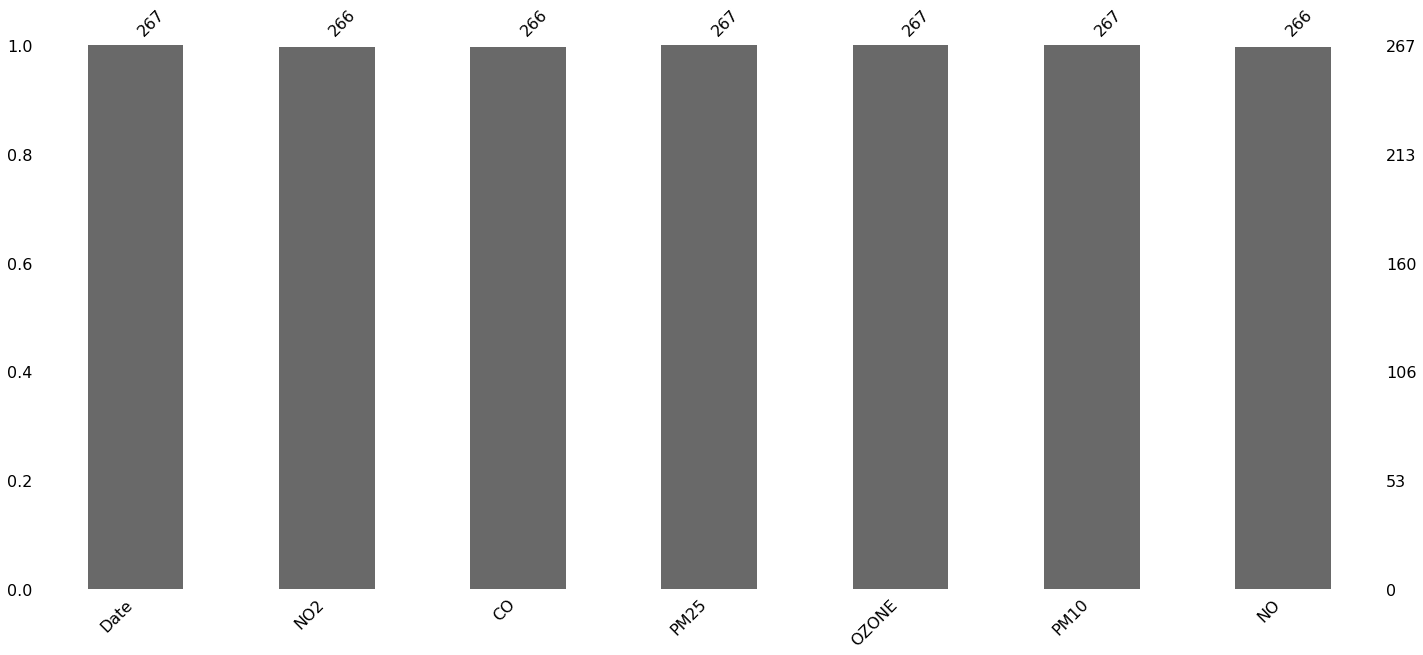

In [8]:
msno.bar(data_df)

In [9]:
# Interpolate missing data  
data_df = data_df.interpolate()
data_df

,Date,NO2,CO,PM25,OZONE,PM10,NO
0,2020-01-26,0.020,0.4930,47.3,0.040,50.5,0.005
1,2020-01-27,0.042,0.8220,24.6,0.041,40.8,0.071
2,2020-01-28,0.042,0.7370,14.9,0.042,27.8,0.083
3,2020-01-29,0.031,0.7320,11.0,0.042,44.7,0.037
4,2020-01-30,0.043,1.0460,16.2,0.038,42.0,0.094
...,...,...,...,...,...,...,...
262,2020-10-14,0.040,1.0230,22.4,0.060,47.0,0.049
263,2020-10-15,0.057,0.7690,22.9,0.059,48.8,0.054
264,2020-10-16,0.041,0.7105,21.4,0.050,50.9,0.034
265,2020-10-17,0.025,0.6520,19.1,0.047,41.2,0.014


In [156]:
#https://raw.githubusercontent.com/datadesk/california-coronavirus-data/master/latimes-county-totals.csv
target_df = pd.read_csv('/Users/kevinmarlis/Developer/Thesis/Covid/latimes-county-totals.csv')
target_df = target_df[target_df['county'] == 'Los Angeles']
target_df = target_df[['date', 'new_confirmed_cases', 'new_deaths']]
target_df = target_df.rename(columns={"date": "Date"})
target_df["Date"] = pd.to_datetime(target_df["Date"])
target_df = target_df.sort_values("Date", ignore_index=True)
target_df = target_df[(target_df['Date'] >= start_date) & (target_df['Date'] <= end_date)] 
target_df = target_df.interpolate(method ='linear', limit_direction ='backward', limit = 1)
target_df

,Date,new_confirmed_cases,new_deaths
0,2020-01-26,0.0,0.0
1,2020-01-27,0.0,0.0
2,2020-01-28,0.0,0.0
3,2020-01-29,0.0,0.0
4,2020-01-30,0.0,0.0
...,...,...,...
262,2020-10-14,1223.0,19.0
263,2020-10-15,1201.0,22.0
264,2020-10-16,1041.0,22.0
265,2020-10-17,923.0,7.0


In [163]:
df = pd.merge(left=data_df, right=target_df)
df = df.set_index('Date', drop=True)
df.index = pd.to_datetime(df.index)
df['7_day_avg_new_cases'] = df[['new_confirmed_cases']].shift().rolling(7).mean().fillna(0)
df['7_day_avg_new_deaths'] = df[['new_deaths']].shift().rolling(7).mean().fillna(0)
df

,NO2,CO,PM25,OZONE,PM10,NO,new_confirmed_cases,new_deaths,7_day_avg_new_cases,7_day_avg_new_deaths
Date,,,,,,,,,,
2020-01-26,0.020,0.4930,47.3,0.040,50.5,0.005,0.0,0.0,0.000000,0.000000
2020-01-27,0.042,0.8220,24.6,0.041,40.8,0.071,0.0,0.0,0.000000,0.000000
2020-01-28,0.042,0.7370,14.9,0.042,27.8,0.083,0.0,0.0,0.000000,0.000000
2020-01-29,0.031,0.7320,11.0,0.042,44.7,0.037,0.0,0.0,0.000000,0.000000
2020-01-30,0.043,1.0460,16.2,0.038,42.0,0.094,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
2020-10-14,0.040,1.0230,22.4,0.060,47.0,0.049,1223.0,19.0,1124.714286,15.571429
2020-10-15,0.057,0.7690,22.9,0.059,48.8,0.054,1201.0,22.0,1075.571429,14.714286
2020-10-16,0.041,0.7105,21.4,0.050,50.9,0.034,1041.0,22.0,1069.142857,15.285714


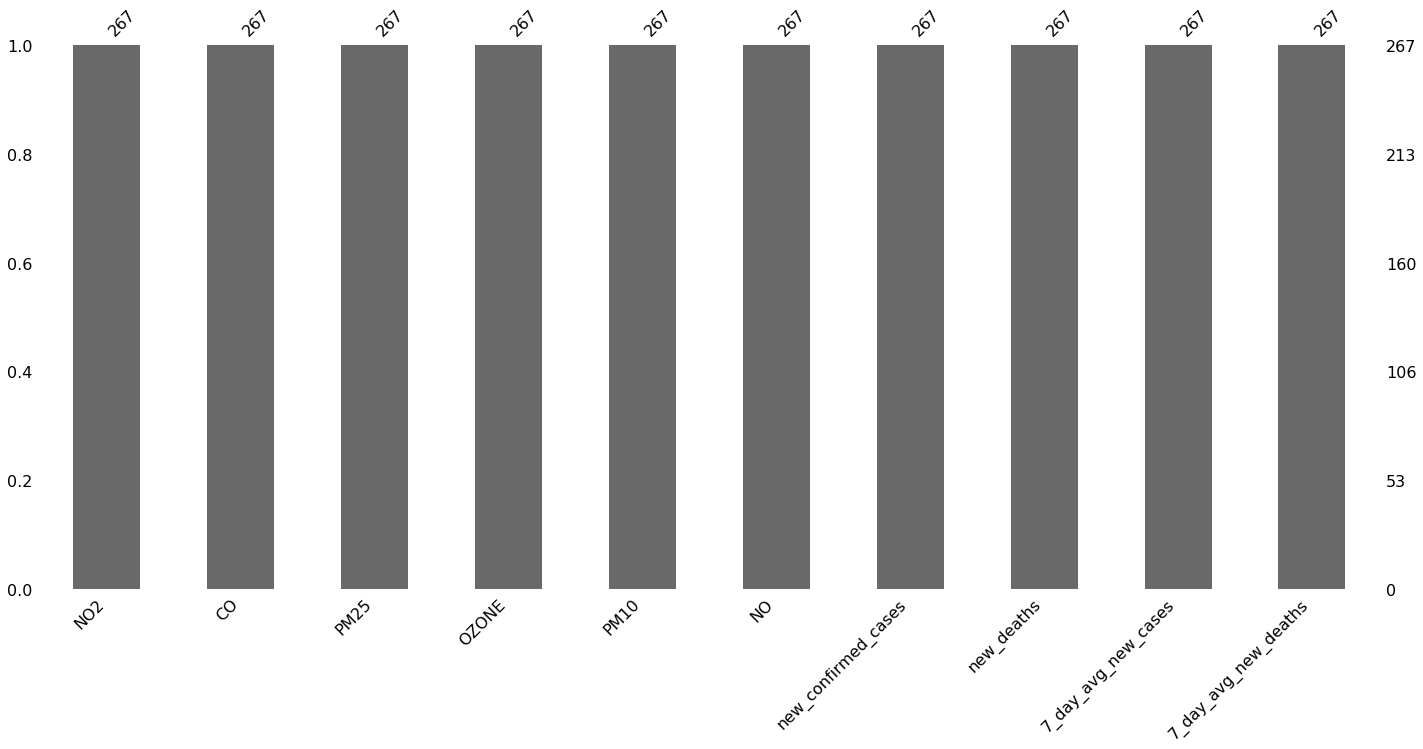

In [164]:
msno.bar(df)

,NO2,CO,PM25,OZONE,PM10,NO,new_confirmed_cases,7_day_avg_new_cases
Date,,,,,,,,
2020-01-26,0.020,0.4930,47.3,0.040,50.5,0.005,0.0,0.000000
2020-01-27,0.042,0.8220,24.6,0.041,40.8,0.071,0.0,0.000000
2020-01-28,0.042,0.7370,14.9,0.042,27.8,0.083,0.0,0.000000
2020-01-29,0.031,0.7320,11.0,0.042,44.7,0.037,0.0,0.000000
2020-01-30,0.043,1.0460,16.2,0.038,42.0,0.094,0.0,0.000000
...,...,...,...,...,...,...,...,...
2020-10-14,0.040,1.0230,22.4,0.060,47.0,0.049,1223.0,1124.714286
2020-10-15,0.057,0.7690,22.9,0.059,48.8,0.054,1201.0,1075.571429
2020-10-16,0.041,0.7105,21.4,0.050,50.9,0.034,1041.0,1069.142857


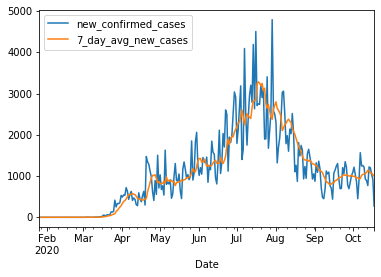

In [161]:
new_cases_df = df.copy(deep=True)
new_cases_df = new_cases_df.drop('new_deaths', axis=1)
new_cases_df['7_day_avg_new_cases'] = new_cases_df[['new_confirmed_cases']].shift().rolling(7).mean().fillna(0)
new_cases_df.plot(y=['new_confirmed_cases', '7_day_avg_new_cases'])
new_cases_df

,NO2,CO,PM25,OZONE,PM10,NO,new_deaths,7_day_avg_new_deaths
Date,,,,,,,,
2020-01-26,0.020,0.4930,47.3,0.040,50.5,0.005,0.0,0.000000
2020-01-27,0.042,0.8220,24.6,0.041,40.8,0.071,0.0,0.000000
2020-01-28,0.042,0.7370,14.9,0.042,27.8,0.083,0.0,0.000000
2020-01-29,0.031,0.7320,11.0,0.042,44.7,0.037,0.0,0.000000
2020-01-30,0.043,1.0460,16.2,0.038,42.0,0.094,0.0,0.000000
...,...,...,...,...,...,...,...,...
2020-10-14,0.040,1.0230,22.4,0.060,47.0,0.049,19.0,15.571429
2020-10-15,0.057,0.7690,22.9,0.059,48.8,0.054,22.0,14.714286
2020-10-16,0.041,0.7105,21.4,0.050,50.9,0.034,22.0,15.285714


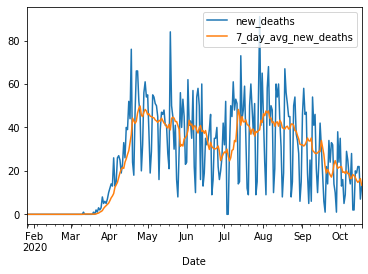

In [159]:
new_deaths_df = df.copy(deep=True)
new_deaths_df = new_deaths_df.drop('new_confirmed_cases', axis=1)
new_deaths_df['7_day_avg_new_deaths'] = new_deaths_df[['new_deaths']].shift().rolling(7).mean().fillna(0)
new_deaths_df.plot(y=['new_deaths', '7_day_avg_new_deaths'])
new_deaths_df

In [165]:
df.to_csv('data.csv')
new_cases_df.to_csv('new_cases')
new_deaths_df.to_csv('new_deaths')

In [127]:
shift_val = 21
correlations = []
for i in range(1, shift_val + 1):
    shifted_df = new_cases_df.copy(deep=True)
    shifted_df['new_confirmed_cases'] = shifted_df['new_confirmed_cases'].shift(i)
    shifted_df = shifted_df.interpolate(method ='linear', limit_direction ='backward')
    correlation = shifted_df.corr().abs()
    correlation = correlation.drop(correlation.index[[6]])
    correlation = correlation.drop(correlation.columns[[0,1,2,3,4,5]], axis=1)
    correlations.append(correlation)

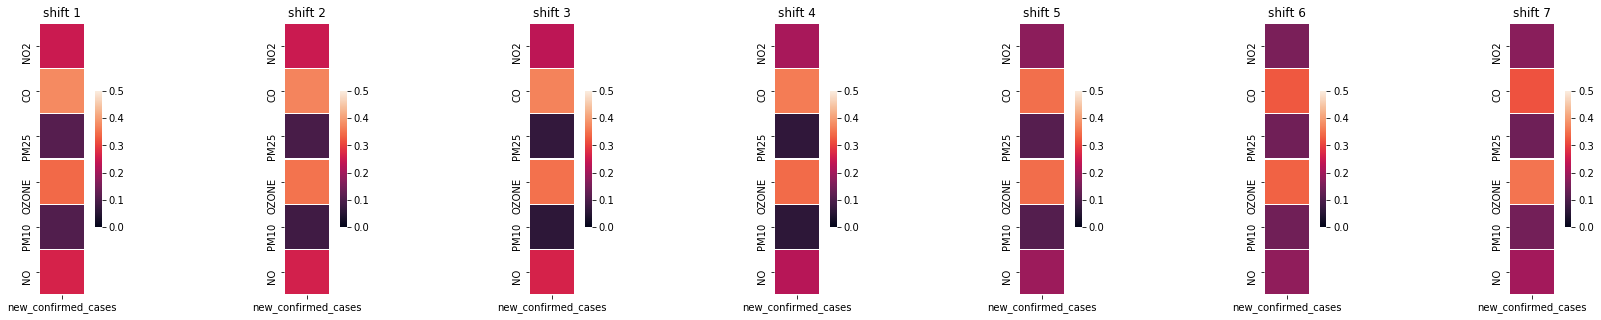

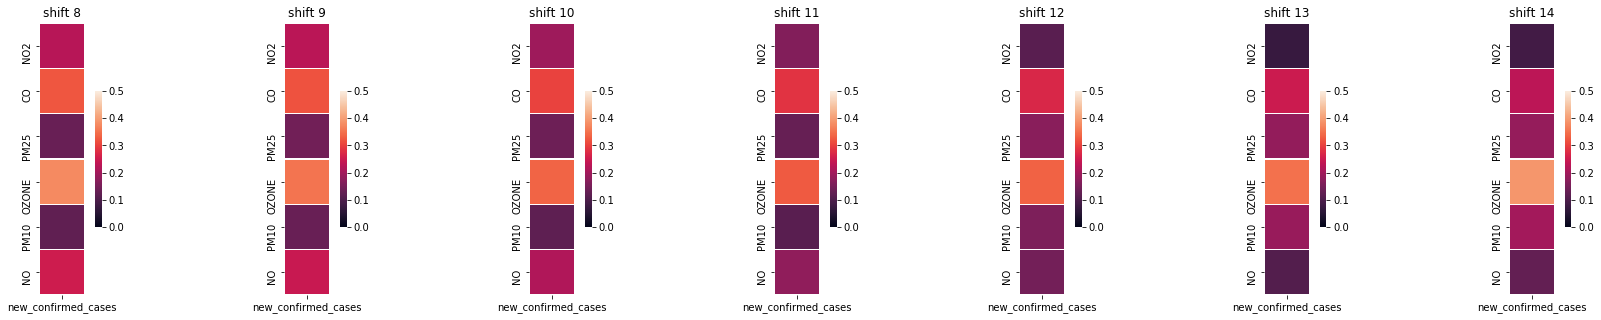

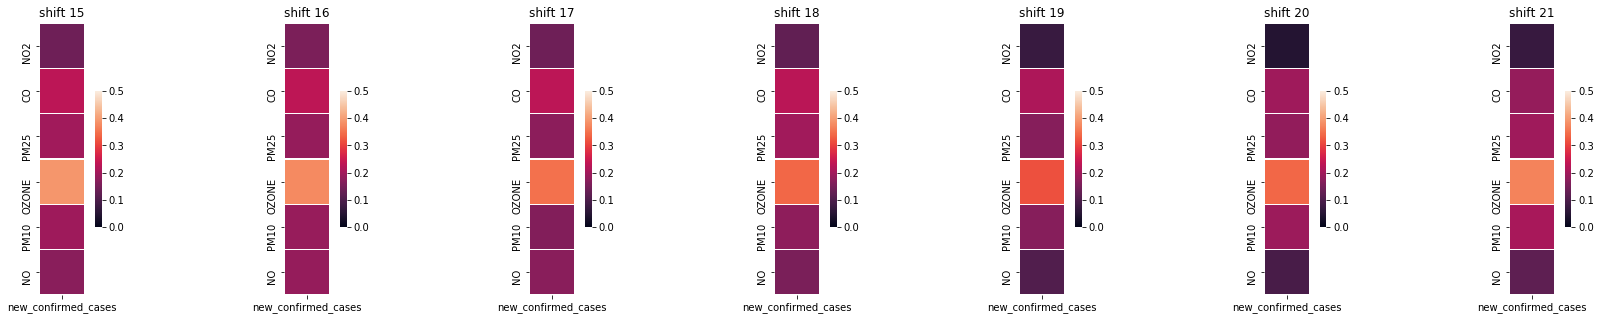

In [130]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(1,7, figsize=(30, 5))
ax1.set_title("shift 1")
ax2.set_title("shift 2")
ax3.set_title("shift 3")
ax4.set_title("shift 4")
ax5.set_title("shift 5")
ax6.set_title("shift 6")
ax7.set_title("shift 7")

sns.heatmap(correlations[0], square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=0, vmax=0.5, ax=ax1)
sns.heatmap(correlations[1], square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=0, vmax=0.5, ax=ax2)
sns.heatmap(correlations[2], square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=0, vmax=0.5, ax=ax3)
sns.heatmap(correlations[3], square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=0, vmax=0.5, ax=ax4)
sns.heatmap(correlations[4], square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=0, vmax=0.5, ax=ax5)
sns.heatmap(correlations[5], square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=0, vmax=0.5, ax=ax6)
sns.heatmap(correlations[6], square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=0, vmax=0.5, ax=ax7)
plt.show()

fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(1,7, figsize=(30, 5))
ax1.set_title("shift 8")
ax2.set_title("shift 9")
ax3.set_title("shift 10")
ax4.set_title("shift 11")
ax5.set_title("shift 12")
ax6.set_title("shift 13")
ax7.set_title("shift 14")

sns.heatmap(correlations[7], square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=0, vmax=0.5, ax=ax1)
sns.heatmap(correlations[8], square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=0, vmax=0.5, ax=ax2)
sns.heatmap(correlations[9], square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=0, vmax=0.5, ax=ax3)
sns.heatmap(correlations[10], square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=0, vmax=0.5, ax=ax4)
sns.heatmap(correlations[11], square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=0, vmax=0.5, ax=ax5)
sns.heatmap(correlations[12], square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=0, vmax=0.5, ax=ax6)
sns.heatmap(correlations[13], square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=0, vmax=0.5, ax=ax7)
plt.show()

fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(1,7, figsize=(30, 5))
ax1.set_title("shift 15")
ax2.set_title("shift 16")
ax3.set_title("shift 17")
ax4.set_title("shift 18")
ax5.set_title("shift 19")
ax6.set_title("shift 20")
ax7.set_title("shift 21")

sns.heatmap(correlations[14], square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=0, vmax=0.5, ax=ax1)
sns.heatmap(correlations[15], square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=0, vmax=0.5, ax=ax2)
sns.heatmap(correlations[16], square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=0, vmax=0.5, ax=ax3)
sns.heatmap(correlations[17], square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=0, vmax=0.5, ax=ax4)
sns.heatmap(correlations[18], square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=0, vmax=0.5, ax=ax5)
sns.heatmap(correlations[19], square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=0, vmax=0.5, ax=ax6)
sns.heatmap(correlations[20], square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=0, vmax=0.5, ax=ax7)
plt.show()